In [6]:
# navigate to project directory
import sys, os
os.chdir(os.path.dirname(sys.path[0]))
sys.path.append(os.path.join(os.path.dirname(sys.path[0]), 'src'))

In [7]:
####################################### BASE CONFIGURATION #########################################
from loguru import logger
import torch
import utils


decoder_channels = (256, 128, 64, 32, 16) 
lr = 0.001
batch_size = 6
encoder_weights = "imagenet" 
encoder_depth = len(decoder_channels)
classes = 1
in_channels = 3
patience = 11
seed = 42
nr_epochs = 80
activation = None
# SUBMISSION
submission_dir = "submissions"
submission_weights = "submission_weights"
submission_checkpoints = "submission_checkpoints"
os.makedirs(submission_dir, exist_ok=True)
os.makedirs(submission_weights, exist_ok=True)
os.makedirs(submission_checkpoints, exist_ok=True)

device = "cpu" # torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Device: {device}")
logger.info(f"Parameters used: Decoder channels: {decoder_channels}, Learning rate: {lr}, Batch size: {batch_size}, Encoder weights: {encoder_weights}, Encoder depth: {encoder_depth}, Classes: {classes}, In channels: {in_channels}, Patience: {patience}, Seed: {seed}, Number of epochs: {nr_epochs}, Activation: {activation}")

####################################### BASE CONFIGURATION END #####################################

nr_models = 6
model_configs = [("efficientnet-b4", "unet++"), ("resnet50", "unet"), ("resnet50", "deeplabv3+"), ("resnet34", "unet++"), ("resnet50", "unet++"), ("xception", "unet++" )]
model_configs = model_configs[:nr_models]

logs/training/2024-07-30__09-16-36/log.log


2024-07-30 09:16:37.137 | DEBUG    | utils:set_seed:28 - Setting seed 42


2024-07-30 09:16:37 | utils | Setting seed 42


2024-07-30 09:16:37.140 | INFO     | __main__:<module>:27 - Device: cpu


2024-07-30 09:16:37 | 153476465 | Device: cpu


2024-07-30 09:16:37.141 | INFO     | __main__:<module>:28 - Parameters used: Decoder channels: (256, 128, 64, 32, 16), Learning rate: 0.001, Batch size: 6, Encoder weights: imagenet, Encoder depth: 5, Classes: 1, In channels: 3, Patience: 11, Seed: 42, Number of epochs: 80, Activation: None


2024-07-30 09:16:37 | 153476465 | Parameters used: Decoder channels: (256, 128, 64, 32, 16), Learning rate: 0.001, Batch size: 6, Encoder weights: imagenet, Encoder depth: 5, Classes: 1, In channels: 3, Patience: 11, Seed: 42, Number of epochs: 80, Activation: None


In [3]:
################################## LOAD DATA #######################################################
from glob import glob
import globals
import torch
import os

from dataset.LazyImageDataset import train_test_split_paths
from models.UNetEncoder import load_dataset

# RAW DATASET

def get_dataloader(seed, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), batch_size=globals.BATCH_SIZE):
    raw_image_paths = (
        glob(os.path.join(globals.ROOT_PATH, "training", "images", "*.png"))
        + glob(os.path.join(globals.ROOT_PATH, "training", "images", "*.jpg"))
    )
    raw_mask_paths = (
        glob(os.path.join(globals.ROOT_PATH, "training", "groundtruth", "*.png"))
        + glob(os.path.join(globals.ROOT_PATH, "training", "groundtruth", "*.jpg"))
    )
    raw_image_paths = sorted(raw_image_paths)
    raw_mask_paths = sorted(raw_mask_paths)
    assert len(raw_image_paths) == len(raw_mask_paths), "Number of images and masks must be equal"
    assert raw_image_paths[-20][-8:-4] == raw_mask_paths[-20][-8:-4], "Image and mask must have the same name"
    train_raw_image_paths, train_raw_mask_paths, val_raw_image_paths, val_raw_mask_paths = train_test_split_paths(
        raw_image_paths, raw_mask_paths, test_size=0.1, seed=seed
    )
    # CURATED DATASET
    curated_image_paths = (
        glob(os.path.join(globals.EXTERNAL_PATH, "curated_100", "images", "*.png"))
        + glob(os.path.join(globals.EXTERNAL_PATH, "curated_100", "images", "*.jpg"))
    )
    curated_mask_paths = (
        glob(os.path.join(globals.EXTERNAL_PATH, "curated_100", "masks", "*.png"))
        + glob(os.path.join(globals.EXTERNAL_PATH, "curated_100", "masks", "*.jpg"))
    )
    curated_image_paths = sorted(curated_image_paths)
    curated_mask_paths = sorted(curated_mask_paths)
    assert len(curated_image_paths) == len(curated_mask_paths), "Number of images and masks must be equal"
    assert curated_image_paths[-20][-8:-4] == curated_mask_paths[-20][-8:-4], "Image and mask must have the same name"
    train_curated_image_paths, train_curated_mask_paths, valid_curated_image_paths, valid_curated_mask_paths = train_test_split_paths(
        curated_image_paths, curated_mask_paths, test_size=0.01, seed=seed
    )
    train_image_paths_combined = train_raw_image_paths + train_curated_image_paths
    train_mask_paths_combined = train_raw_mask_paths + train_curated_mask_paths
    val_image_paths_combined = val_raw_image_paths + valid_curated_image_paths
    val_mask_paths_combined = val_raw_mask_paths + valid_curated_mask_paths

    # CUT TO MULTIPLE OF BATCH SIZE
    train_image_paths_combined = train_image_paths_combined[:len(train_image_paths_combined) - len(train_image_paths_combined) % batch_size]
    train_mask_paths_combined = train_mask_paths_combined[:len(train_mask_paths_combined) - len(train_mask_paths_combined) % batch_size]
    val_image_paths_combined = val_image_paths_combined[:len(val_image_paths_combined) - len(val_image_paths_combined) % batch_size]
    val_mask_paths_combined = val_mask_paths_combined[:len(val_mask_paths_combined) - len(val_mask_paths_combined) % batch_size]


    # COMBINED LAZY DATASET
    train_dataset_combined, val_dataset_combined = load_dataset(
        device, train_image_paths_combined, train_mask_paths_combined, val_image_paths_combined, val_mask_paths_combined, use_patches=False, is_lazy=True
    )

    combined_train_dataloader = torch.utils.data.DataLoader(
        train_dataset_combined, batch_size=batch_size, shuffle=True
    )
    combined_validation_dataloader = torch.utils.data.DataLoader(
        val_dataset_combined, batch_size=batch_size, shuffle=False
    )
    return combined_train_dataloader, combined_validation_dataloader

def get_raw_dataloader(seed, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), batch_size=globals.BATCH_SIZE):
    raw_image_paths = (
        glob(os.path.join(globals.ROOT_PATH, "training", "images", "*.png"))
        + glob(os.path.join(globals.ROOT_PATH, "training", "images", "*.jpg"))
    )
    raw_mask_paths = (
        glob(os.path.join(globals.ROOT_PATH, "training", "groundtruth", "*.png"))
        + glob(os.path.join(globals.ROOT_PATH, "training", "groundtruth", "*.jpg"))
    )
    raw_image_paths = sorted(raw_image_paths)
    raw_mask_paths = sorted(raw_mask_paths)
    assert len(raw_image_paths) == len(raw_mask_paths), "Number of images and masks must be equal"
    assert raw_image_paths[-20][-8:-4] == raw_mask_paths[-20][-8:-4], "Image and mask must have the same name"
    train_raw_image_paths, train_raw_mask_paths, val_raw_image_paths, val_raw_mask_paths = train_test_split_paths(
        raw_image_paths, raw_mask_paths, test_size=0.1, seed=seed
    )
    
    # CUT TO MULTIPLE OF BATCH SIZE
    train_raw_image_paths = train_raw_image_paths[:len(train_raw_image_paths) - len(train_raw_image_paths) % batch_size]
    train_raw_mask_paths = train_raw_mask_paths[:len(train_raw_mask_paths) - len(train_raw_mask_paths) % batch_size]
    val_raw_image_paths = val_raw_image_paths[:len(val_raw_image_paths) - len(val_raw_image_paths) % batch_size]
    val_raw_mask_paths = val_raw_mask_paths[:len(val_raw_mask_paths) - len(val_raw_mask_paths) % batch_size]


    # COMBINED LAZY DATASET
    train_dataset_raw, val_dataset_raw = load_dataset(
        device, train_raw_image_paths, train_raw_mask_paths, val_raw_image_paths, val_raw_mask_paths, use_patches=False, is_lazy=True
    )

    raw_train_dataloader = torch.utils.data.DataLoader(
        train_dataset_raw, batch_size=batch_size, shuffle=True
    )
    raw_validation_dataloader = torch.utils.data.DataLoader(
        val_dataset_raw, batch_size=batch_size, shuffle=False
    )
    return raw_train_dataloader, raw_validation_dataloader
    ################################## LOAD DATA END ###################################################

In [4]:
import segmentation_models_pytorch as smp
from models.UNetEncoder import UNetEncoder
from models.UNetResNetASPPMultiAttention import UNetEncoderASPP

loss_fn = None
metric_fns_base = {
    "acc": utils.accuracy_fn,
    "patch_acc": utils.patch_accuracy_fn,
    "f1": utils.f1_score_fn,
    "patch_f1": utils.patch_f1_score_fn,
}
metric_fns_sig = {
    "acc": lambda y1, y2: utils.accuracy_fn(torch.sigmoid(y1), y2),
    "patch_acc": lambda y1, y2: utils.patch_accuracy_fn(torch.sigmoid(y1), y2),
    "f1": lambda y1, y2: utils.f1_score_fn(torch.sigmoid(y1), y2),
    "patch_f1": lambda y1, y2: utils.patch_f1_score_fn(torch.sigmoid(y1), y2),
}
metric_fns = None
freeze_encoder = False

# CREATE MODEL FUNCTION

def create_model(encoder_name, architecture):
    """Create the model based on the encoder_name and the architecture
    Args:
        encoder_name (str): the name of the encoder, e.g. resnet50, efficientnet-b4, xception
        architecture (str): the name of the architecture, e.g. unet, unet++, deeplabv3+
    """
    global freeze_encoder, metric_fns, metric_fns_sig, loss_fn

    metric_fns = metric_fns_sig
    freeze_encoder = "resnet" in encoder_name
    loss_fn = torch.nn.BCEWithLogitsLoss()
    if architecture == "unet":
        loss_fn = torch.nn.BCELoss() # BCEWithLogitsLoss would apply sigmoid a second time
        metric_fns = metric_fns_base
        model = UNetEncoder()
        model.freeze_encoder()
    elif architecture == "unet++":
        model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_depth=encoder_depth,
            encoder_weights=encoder_weights,
            decoder_channels=decoder_channels,
            in_channels=in_channels,
            classes=classes,
            activation=activation,
        )
    elif architecture == "deeplabv3+":
        model = smp.DeepLabV3Plus(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes,
            activation=activation,
        )
    elif architecture == "unet_aspp":
        model = UNetEncoderASPP(out_channels=classes, dropout_rate=0.5, num_heads=8)

    ########### FREEZE ENCODER IF NECESSARY ################
    if freeze_encoder and architecture != "unet":
        for child in list(model.encoder.children())[:5]:
            for param in child.parameters():
                param.requires_grad = False
    return model

In [5]:
from time import sleep


model_configs = [
    #("xception", "unet++" ),
    #("resnet50", "unet"),
    #("efficientnet-b4", "unet++"),
    #("resnet50", "deeplabv3+"),
    #("resnet50", "unet++"),
    #("resnet34", "unet++"),
    ("resnet50", "unet_aspp")]

for i, (encoder_name, architecture) in enumerate(model_configs):
    combined_train_dataloader, combined_validation_dataloader = get_dataloader(seed + i, device, batch_size)
    model = create_model(encoder_name, architecture)
    model = model.to(device)
    model_name = f"{encoder_name}_{architecture}"
    logger.info(f"Training model: {model_name}")
    # check if submission weights exist at submission_weights_path and starts with model_name
    submission_weights_path = os.listdir(submission_weights)
    submission_weights_path = [os.path.join(submission_weights, path) for path in submission_weights_path if path.startswith(model_name) and (not "++" in path or "unet++" in model_name)]   
    submission_weights_path = submission_weights_path[0] if submission_weights_path else None
    if submission_weights_path:
        logger.info(f"Loading model weights from {submission_weights_path} as it was already trained.")
        model.load_state_dict(torch.load(submission_weights_path))
    else:
        logger.info(f"No weights found at {submission_weights_path}. Training from scratch.")
        os.makedirs(submission_weights_path := "submission_checkpoints", exist_ok=True)
        for _ in range(2 if "resnet" in encoder_name else 1): # resnet models take longer to train (and are less likely to overfit due to freezing)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            utils.train(combined_train_dataloader, combined_validation_dataloader, model, loss_fn, metric_fns, optimizer, nr_epochs, patience, model_name, submission_weights_path)
        submission_weights_path = os.path.join(submission_weights, f"{model_name}.pt")
        torch.save(model.state_dict(), submission_weights_path)
        sleep(2)
        utils.create_test_submission(model, device=device, submission_filename=os.path.join(submission_dir, f"{model_name}.csv"))
    

2024-07-30 09:16:39.866 | INFO     | __main__:<module>:8 - Training model: efficientnet-b4_unet++


2024-07-30 09:16:39 | 1621413119 | Training model: efficientnet-b4_unet++


2024-07-30 09:16:39.868 | INFO     | __main__:<module>:14 - Loading model weights from submission_weights/efficientnet-b4_unet++-finetuned.pt as it was already trained.


2024-07-30 09:16:39 | 1621413119 | Loading model weights from submission_weights/efficientnet-b4_unet++-finetuned.pt as it was already trained.


2024-07-30 09:16:40.185 | INFO     | models.UNetEncoder:freeze_encoder:113 - Freezing encoder weights enc1, enc2


2024-07-30 09:16:40 | UNetEncoder | Freezing encoder weights enc1, enc2


2024-07-30 09:16:40.189 | INFO     | __main__:<module>:8 - Training model: resnet50_unet


2024-07-30 09:16:40 | 1621413119 | Training model: resnet50_unet


2024-07-30 09:16:40.191 | INFO     | __main__:<module>:14 - Loading model weights from submission_weights/resnet50_unet-finetuned.pt as it was already trained.


2024-07-30 09:16:40 | 1621413119 | Loading model weights from submission_weights/resnet50_unet-finetuned.pt as it was already trained.


2024-07-30 09:16:40.833 | INFO     | __main__:<module>:8 - Training model: resnet50_deeplabv3+


2024-07-30 09:16:40 | 1621413119 | Training model: resnet50_deeplabv3+


2024-07-30 09:16:40.835 | INFO     | __main__:<module>:14 - Loading model weights from submission_weights/resnet50_deeplabv3+.pt as it was already trained.


2024-07-30 09:16:40 | 1621413119 | Loading model weights from submission_weights/resnet50_deeplabv3+.pt as it was already trained.


2024-07-30 09:16:41.419 | INFO     | __main__:<module>:8 - Training model: resnet34_unet++


2024-07-30 09:16:41 | 1621413119 | Training model: resnet34_unet++


2024-07-30 09:16:41.420 | INFO     | __main__:<module>:14 - Loading model weights from submission_weights/resnet34_unet++-finetuned.pt as it was already trained.


2024-07-30 09:16:41 | 1621413119 | Loading model weights from submission_weights/resnet34_unet++-finetuned.pt as it was already trained.


2024-07-30 09:16:42.157 | INFO     | __main__:<module>:8 - Training model: resnet50_unet++


2024-07-30 09:16:42 | 1621413119 | Training model: resnet50_unet++


2024-07-30 09:16:42.158 | INFO     | __main__:<module>:14 - Loading model weights from submission_weights/resnet50_unet++-finetuned.pt as it was already trained.


2024-07-30 09:16:42 | 1621413119 | Loading model weights from submission_weights/resnet50_unet++-finetuned.pt as it was already trained.


2024-07-30 09:16:42.556 | INFO     | __main__:<module>:8 - Training model: xception_unet++


2024-07-30 09:16:42 | 1621413119 | Training model: xception_unet++


2024-07-30 09:16:42.557 | INFO     | __main__:<module>:14 - Loading model weights from submission_weights/xception_unet++.pt as it was already trained.


2024-07-30 09:16:42 | 1621413119 | Loading model weights from submission_weights/xception_unet++.pt as it was already trained.


In [6]:
from time import sleep

# Out UNet implementation seems to benefit from finetuning, while the other models do not
nr_epochs_finetune = 24
patience_finetune = 8
finetune_li = [("efficientnet-b4", "unet++"), ("resnet50", "unet"), ("resnet50", "deeplabv3+")] # needed to set correct seed
for i, (encoder_name, architecture) in enumerate(model_configs):
    if not (encoder_name, architecture) in finetune_li:
        logger.info(f"Skipping finetuning for {encoder_name}_{architecture}")
        continue
    raw_train_dataloader, raw_validation_dataloader = get_raw_dataloader(seed + i, device, batch_size)
    combined_train_dataloader, combined_validation_dataloader = get_dataloader(seed + i, device, batch_size)
    model = create_model(encoder_name, architecture)
    model = model.to(device)
    model_name = f"{encoder_name}_{architecture}"
    logger.info(f"Training model: {model_name}")
    # check if submission weights exist at submission_weights_path and starts with model_name
    submission_weights_path = os.listdir(submission_weights)
    submission_path_finetuned = [os.path.join(submission_weights, path) for path in submission_weights_path if path.startswith(model_name) and (not "++" in path or "unet++" in model_name) and "finetuned" in path]
    if submission_path_finetuned:
        submission_path_finetuned = submission_path_finetuned[0]
        logger.info(f"Loading model weights from {submission_path_finetuned} as it was already finetuned.")
        model.load_state_dict(torch.load(submission_path_finetuned))
        continue
    submission_weights_path = [os.path.join(submission_weights, path) for path in submission_weights_path if path.startswith(model_name) and (not "++" in path or "unet++" in model_name)]    
    submission_weights_path = submission_weights_path[0] if submission_weights_path else None
    if submission_weights_path:
        logger.info(f"Loading model weights from {submission_weights_path}. Starting finetuning.")
        model.load_state_dict(torch.load(submission_weights_path))
        model_name = f"{encoder_name}_{architecture}-finetuned"
        os.makedirs(submission_weights_path := "submission_checkpoints", exist_ok=True)
        for _ in range(2 if "resnet" in encoder_name else 1): # our unet takes longer to train
            optimizer = torch.optim.Adam(model.parameters(), lr=lr / 4) # mutable
            utils.train(raw_train_dataloader, combined_validation_dataloader, model, loss_fn, metric_fns, optimizer, nr_epochs_finetune, patience_finetune, model_name, submission_weights_path)
        submission_weights_path = os.path.join(submission_weights, f"{model_name}.pt")
        torch.save(model.state_dict(), submission_weights_path)
        sleep(2)
        utils.create_test_submission(model, device=device, submission_filename=os.path.join(submission_dir, f"{model_name}.csv"))
    else:
        logger.error(f"No weights found at {submission_weights_path}. Cannot finetune model.")
        
        

2024-07-30 09:16:42.839 | INFO     | __main__:<module>:16 - Training model: efficientnet-b4_unet++


2024-07-30 09:16:42 | 2459617309 | Training model: efficientnet-b4_unet++


2024-07-30 09:16:42.840 | INFO     | __main__:<module>:22 - Loading model weights from submission_weights/efficientnet-b4_unet++-finetuned.pt as it was already finetuned.


2024-07-30 09:16:42 | 2459617309 | Loading model weights from submission_weights/efficientnet-b4_unet++-finetuned.pt as it was already finetuned.


2024-07-30 09:16:43.063 | INFO     | models.UNetEncoder:freeze_encoder:113 - Freezing encoder weights enc1, enc2


2024-07-30 09:16:43 | UNetEncoder | Freezing encoder weights enc1, enc2


2024-07-30 09:16:43.068 | INFO     | __main__:<module>:16 - Training model: resnet50_unet


2024-07-30 09:16:43 | 2459617309 | Training model: resnet50_unet


2024-07-30 09:16:43.069 | INFO     | __main__:<module>:22 - Loading model weights from submission_weights/resnet50_unet-finetuned.pt as it was already finetuned.


2024-07-30 09:16:43 | 2459617309 | Loading model weights from submission_weights/resnet50_unet-finetuned.pt as it was already finetuned.


2024-07-30 09:16:43.677 | INFO     | __main__:<module>:16 - Training model: resnet50_deeplabv3+


2024-07-30 09:16:43 | 2459617309 | Training model: resnet50_deeplabv3+


2024-07-30 09:16:43.678 | INFO     | __main__:<module>:22 - Loading model weights from submission_weights/resnet50_deeplabv3+-finetuned.pt as it was already finetuned.


2024-07-30 09:16:43 | 2459617309 | Loading model weights from submission_weights/resnet50_deeplabv3+-finetuned.pt as it was already finetuned.


2024-07-30 09:16:43.759 | INFO     | __main__:<module>:9 - Skipping finetuning for resnet34_unet++


2024-07-30 09:16:43 | 2459617309 | Skipping finetuning for resnet34_unet++


2024-07-30 09:16:43.760 | INFO     | __main__:<module>:9 - Skipping finetuning for resnet50_unet++


2024-07-30 09:16:43 | 2459617309 | Skipping finetuning for resnet50_unet++


2024-07-30 09:16:43.760 | INFO     | __main__:<module>:9 - Skipping finetuning for xception_unet++


2024-07-30 09:16:43 | 2459617309 | Skipping finetuning for xception_unet++


In [7]:
import random
from logger import LOG_DIR
from models.MaskInpaintModel import SimpleAutoencoder
import matplotlib.pyplot as plt
from time import sleep


class StreetArtist(torch.nn.Module):
    def __init__(self, *models):
        super().__init__()
        self.models = models # list of models
        self.nr_models = len(models)
        self.street_paint = SimpleAutoencoder(self.nr_models) # one input channel for each model
    
    def forward(self, x):
        model_outputs = [model(x) for model in self.models]
        model_outputs = torch.cat(model_outputs, dim=1)
        return self.street_paint(model_outputs)
    
    def freeze_models(self):
        for model in self.models:
            for param in model.parameters():
                param.requires_grad = False

    def visualize(self, dataloader):
        self.eval()
        self.to(device)
        target = random.randint(0, 5)
        reconstructed_images_models = []
        for i, (images, mask) in enumerate(dataloader):
            if i != target:
                continue
            # detach images
            images = images.detach()
            mask = mask.detach()
            reconstructed_images_models = [model(images).detach() for model in self.models]
            # Uncomment for sigmoid activation
            # reconstructed_images_models[2:] = [torch.sigmoid(reconstructed_images_models[i]).detach() for i in range(2, self.nr_models)]
            # reconstructed_images_models[0] = torch.sigmoid(reconstructed_images_models[0]).detach()
            street_painted_images = self(images).detach()
            # Uncomment for thresholding
            # reconstructed_images_models = [torch.where(reconstructed_images_models[i] > 0.5, torch.tensor(1.0), torch.tensor(0.0)) for i in range(self.nr_models)]
            # street_painted_images = torch.where(street_painted_images > 0.5, torch.tensor(1.0), torch.tensor(0.0))
            break
        fig, axs = plt.subplots(self.nr_models + 3, 4, figsize=(4 * 3, self.nr_models * 5))
        # row 1 : 4 original images
        sleep(5)
        for i in range(4):
            axs[0, i].imshow(images[i].permute(1, 2, 0).cpu().numpy())
            axs[0, i].axis("off")
            axs[0, i].set_title("Original")
        for i in range(self.nr_models):
            # row 2 - n-2 : model reconstructed images
            for j in range(4):
                    axs[i + 1, j].imshow(reconstructed_images_models[i][j].permute(1, 2, 0).cpu().numpy(), cmap="gray")
                    axs[i + 1, j].axis("off")
                    axs[i + 1, j].set_title(f"{model_configs[i][0]}_{model_configs[i][1]}")
        for i in range(4):
            # row n-1 : street painted images
            axs[self.nr_models + 1, i].imshow(street_painted_images[i].permute(1, 2, 0).cpu().numpy(), cmap="gray")
            axs[self.nr_models + 1, i].axis("off")
            axs[self.nr_models + 1, i].set_title("Street Artist")
        for i in range(4):
            # row n : ground truth
            axs[self.nr_models + 2, i].imshow(mask[i].permute(1, 2, 0).cpu().numpy(), cmap="gray")
            axs[self.nr_models + 2, i].axis("off")
            axs[self.nr_models + 2, i].set_title("Ground Truth")
            
        plt.savefig(LOG_DIR + f"/street_artist-{model_name}-{random.randint(0, 1000)}.png")
        plt.show()

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


2024-07-30 09:16:44.571 | INFO     | models.UNetEncoder:freeze_encoder:113 - Freezing encoder weights enc1, enc2


2024-07-30 09:16:44 | UNetEncoder | Freezing encoder weights enc1, enc2
submission_weights/efficientnet-b4_unet++-finetuned.pt
submission_weights/resnet50_unet-finetuned.pt
submission_weights/resnet50_deeplabv3+-finetuned.pt
submission_weights/resnet34_unet++-finetuned.pt
submission_weights/resnet50_unet++-finetuned.pt


2024-07-30 09:16:47.192 | INFO     | __main__:<module>:25 - Training model: street_paintefficientnet-b4_unet++__resnet50_unet__resnet50_deeplabv3+__resnet34_unet++__resnet50_unet++__xception_unet++


submission_weights/xception_unet++.pt
2024-07-30 09:16:47 | 400514689 | Training model: street_paintefficientnet-b4_unet++__resnet50_unet__resnet50_deeplabv3+__resnet34_unet++__resnet50_unet++__xception_unet++


2024-07-30 09:16:47.198 | INFO     | __main__:<module>:33 - Training for 17 epochs with patience 3.


2024-07-30 09:16:47 | 400514689 | Training for 17 epochs with patience 3.


2024-07-30 09:16:47.199 | INFO     | __main__:<module>:36 - Loading model weights from submission_weights/street_paintefficientnet-b4_unet++__resnet50_unet__resnet50_deeplabv3+__resnet34_unet++__resnet50_unet++__xception_unet++_17_3.pt.


2024-07-30 09:16:47 | 400514689 | Loading model weights from submission_weights/street_paintefficientnet-b4_unet++__resnet50_unet__resnet50_deeplabv3+__resnet34_unet++__resnet50_unet++__xception_unet++_17_3.pt.


2024-07-30 09:16:52.545 | ERROR    | __main__:<module>:55 - list index out of range


2024-07-30 09:16:52 | 400514689 | list index out of range


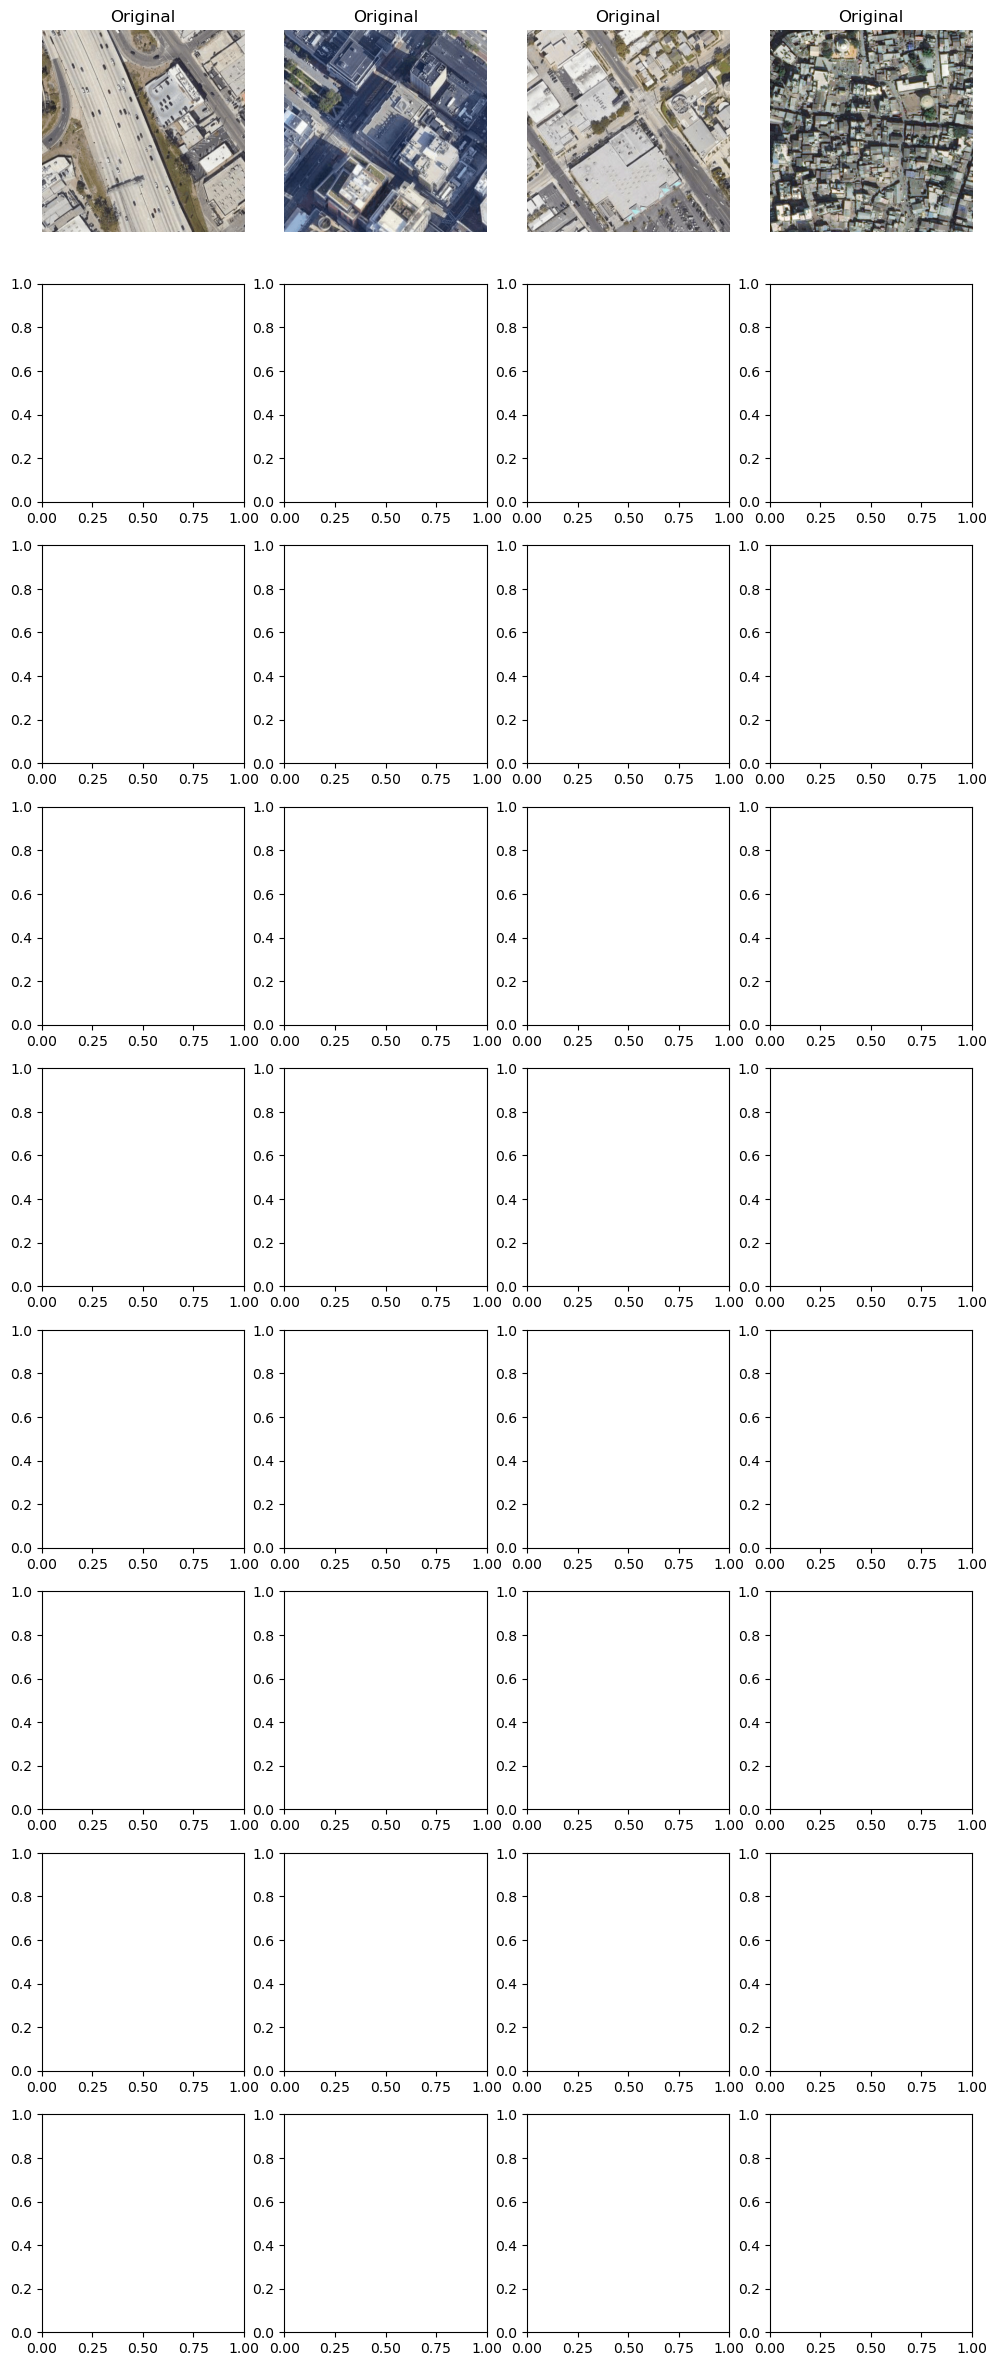

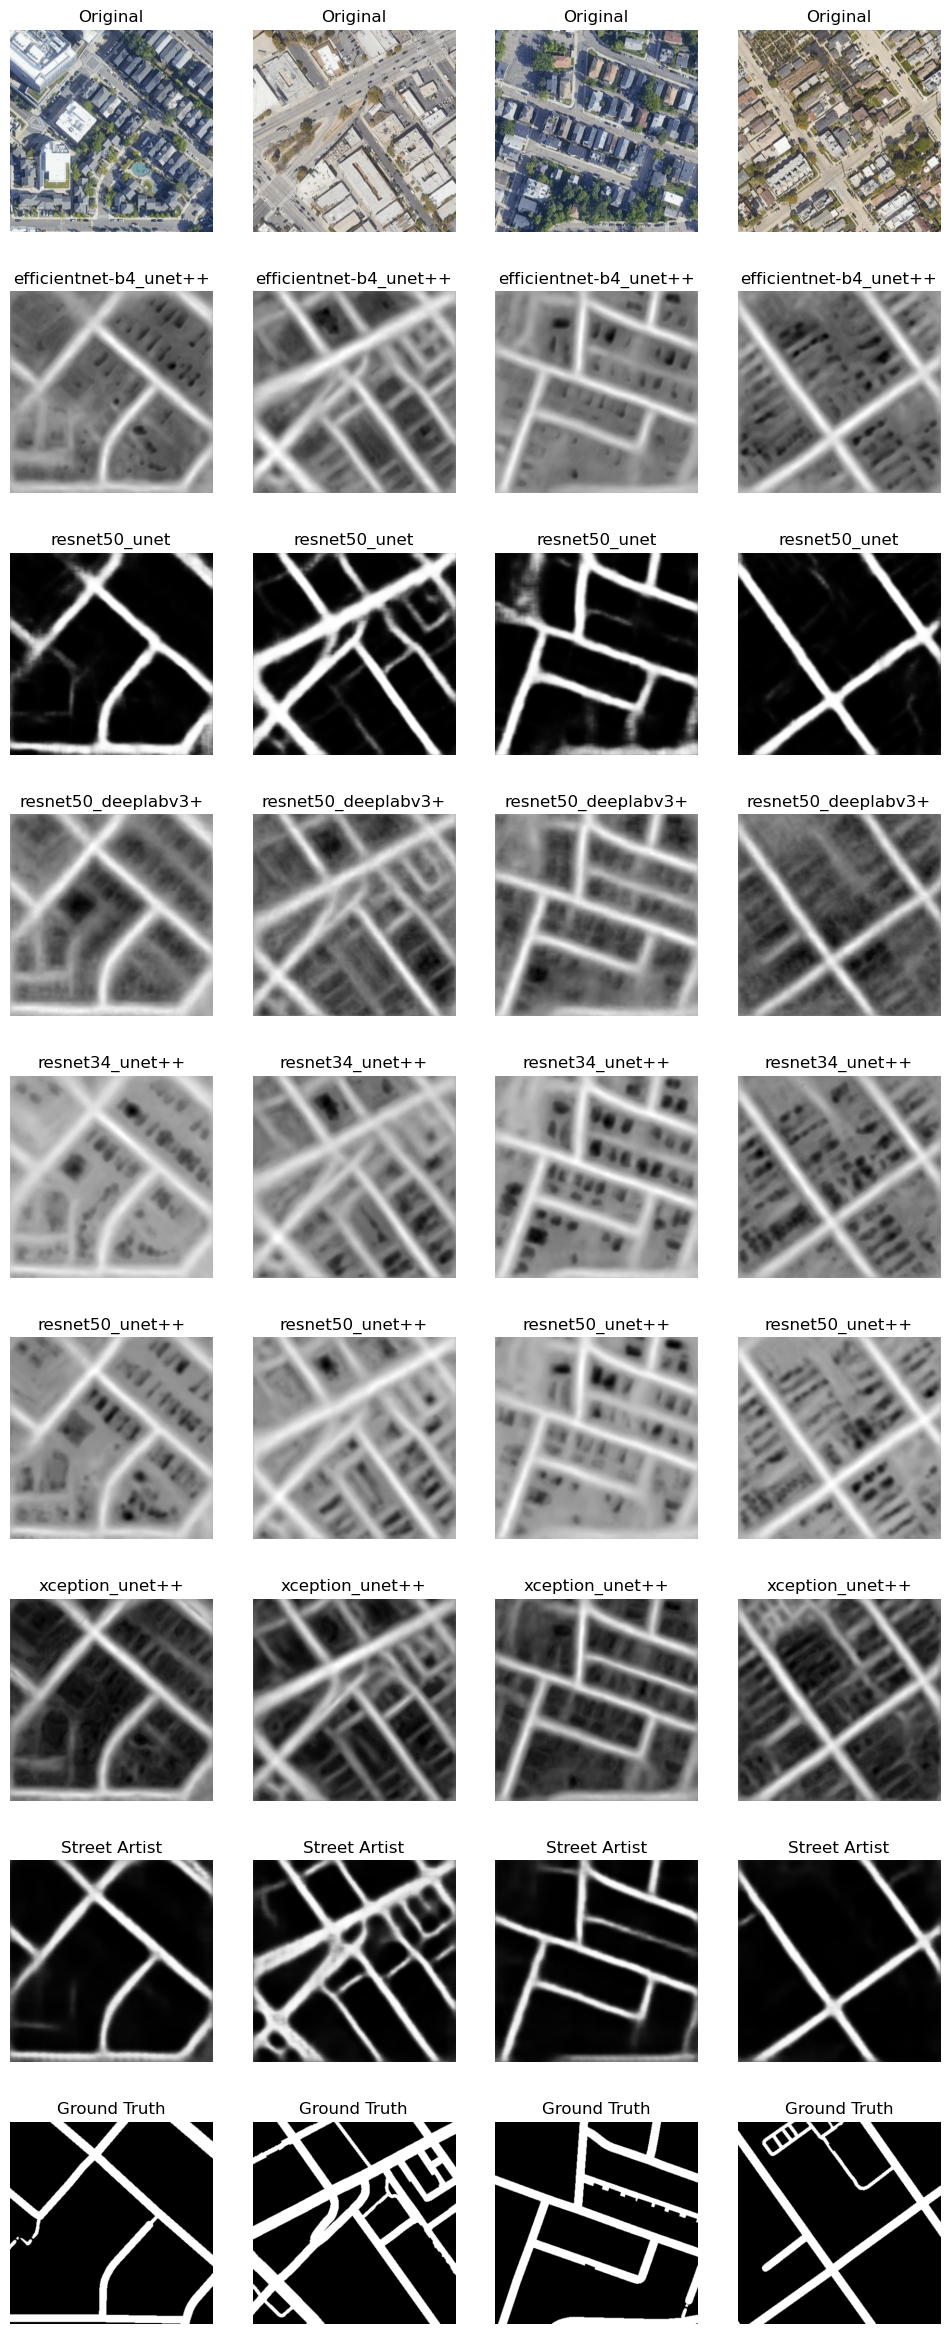

2024-07-30 09:17:25.221 | ERROR    | __main__:<module>:55 - list index out of range


2024-07-30 09:17:25 | 400514689 | list index out of range


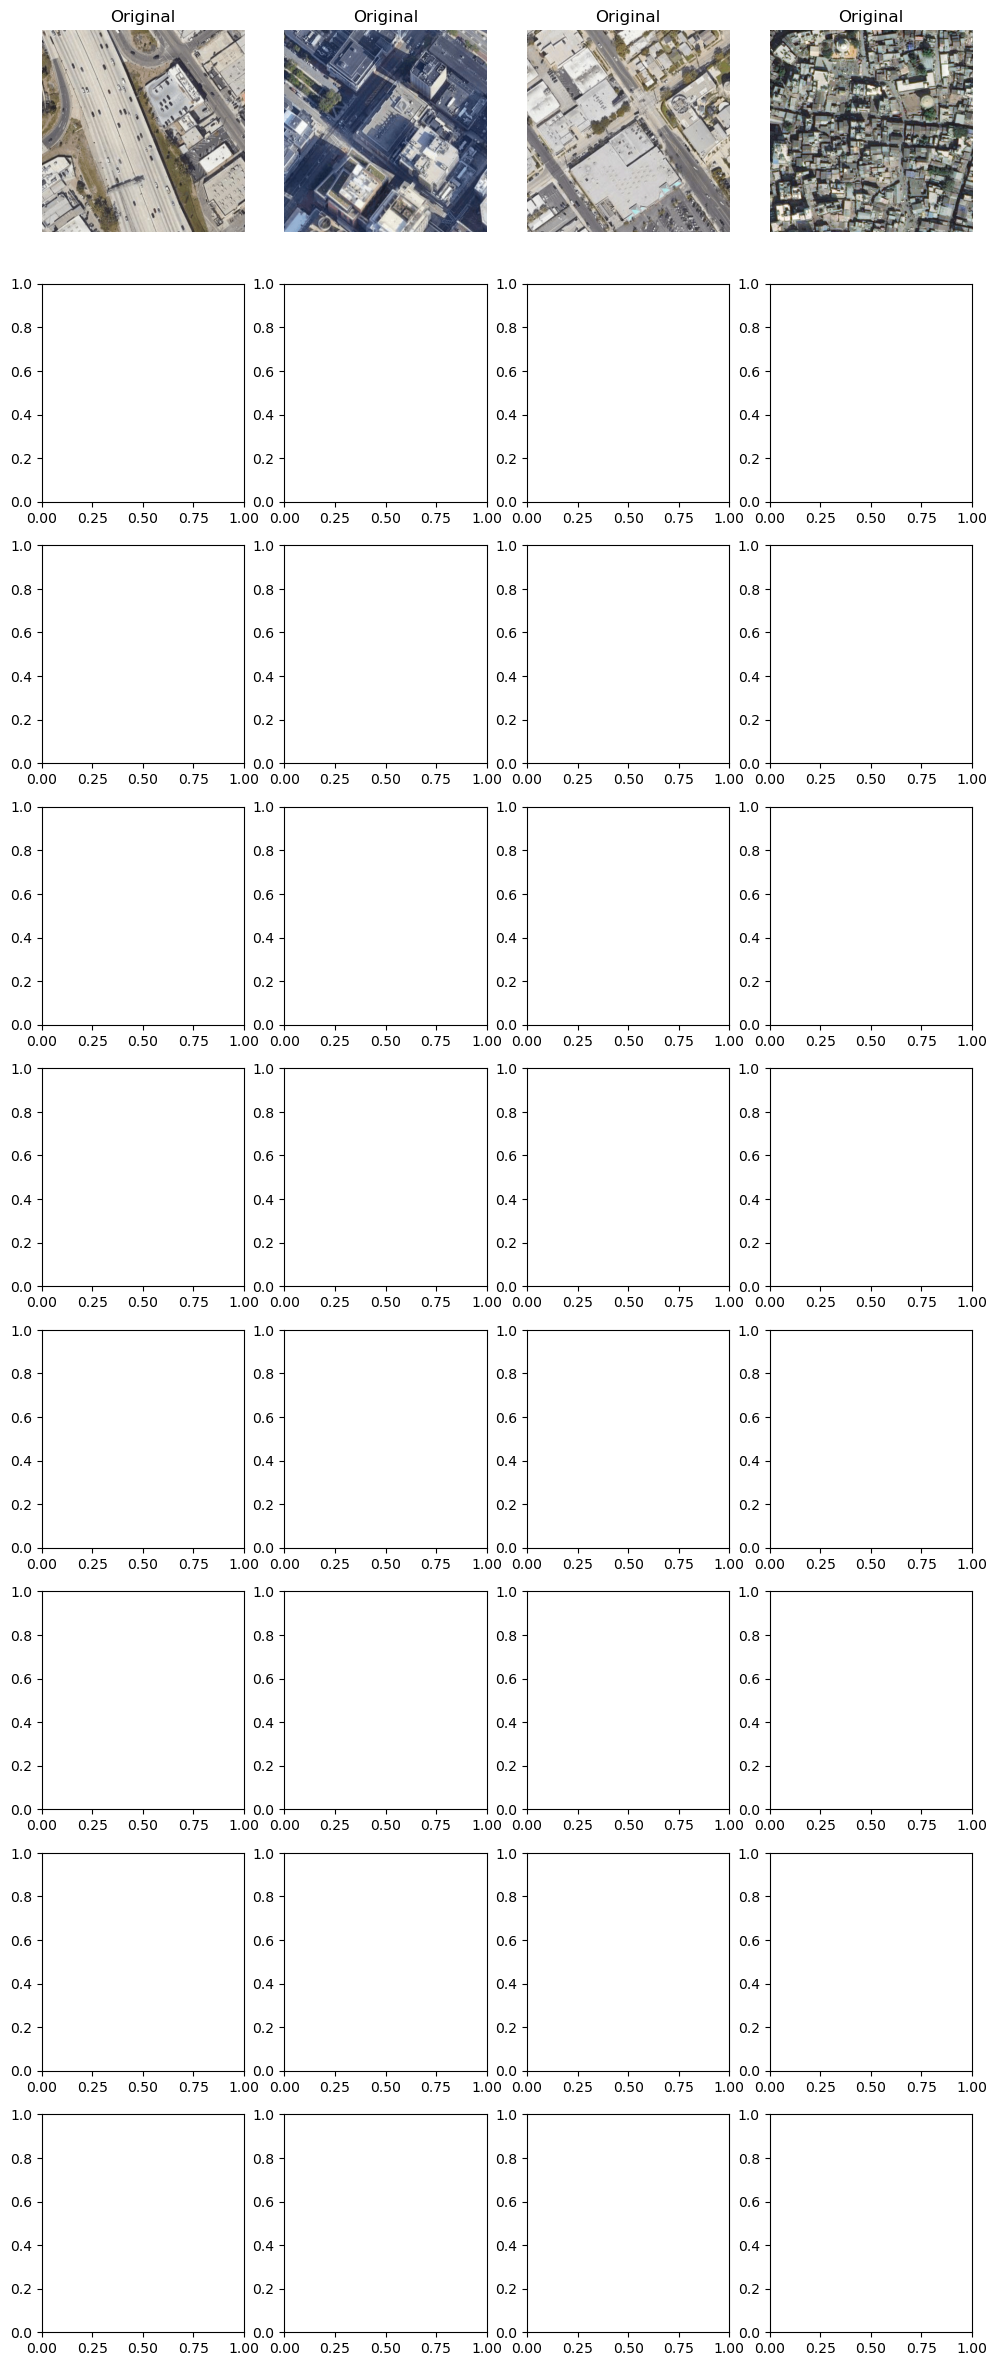

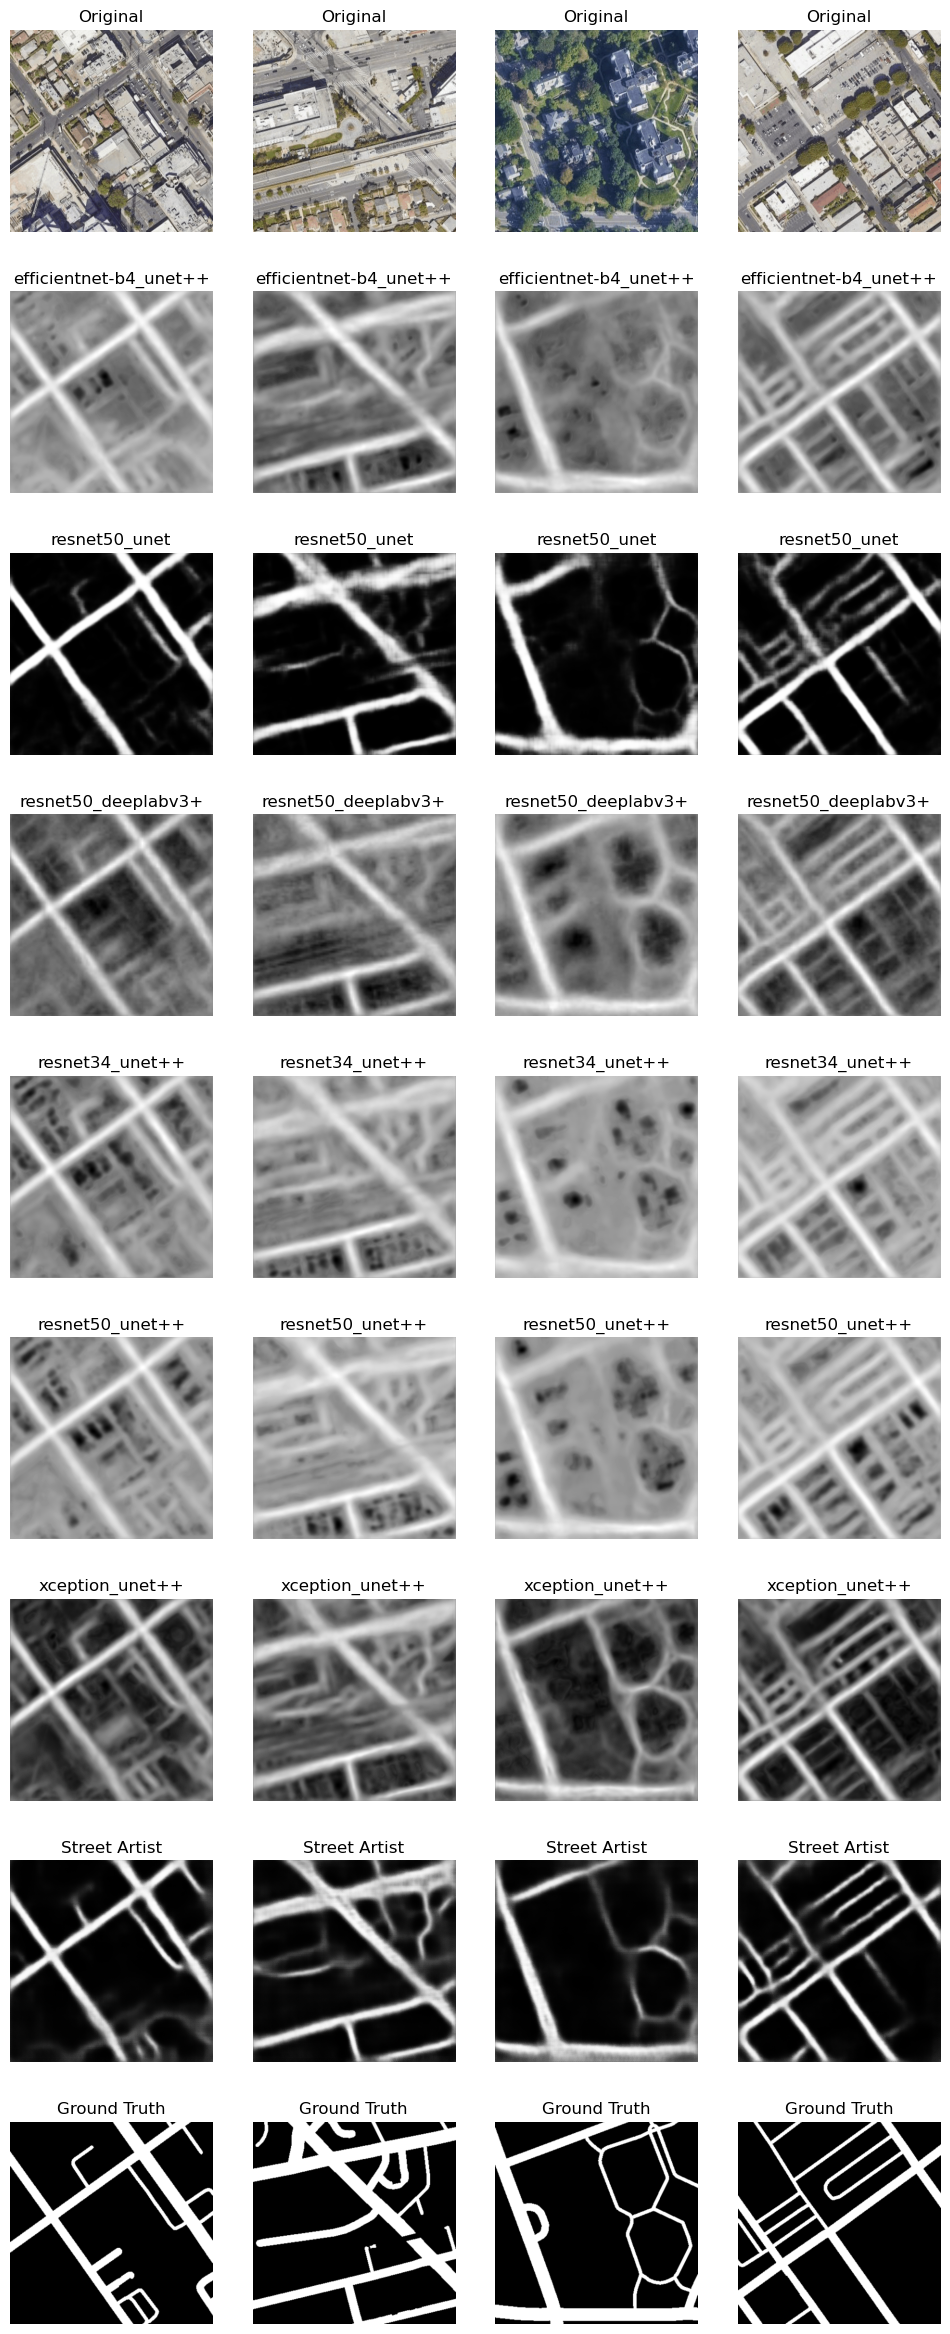

2024-07-30 09:17:50.132 | INFO     | __main__:<module>:33 - Training for 19 epochs with patience 4.


2024-07-30 09:17:50 | 400514689 | Training for 19 epochs with patience 4.


2024-07-30 09:17:50.133 | INFO     | __main__:<module>:36 - Loading model weights from submission_weights/street_paintefficientnet-b4_unet++__resnet50_unet__resnet50_deeplabv3+__resnet34_unet++__resnet50_unet++__xception_unet++_17_3_19_4.pt.


2024-07-30 09:17:50 | 400514689 | Loading model weights from submission_weights/street_paintefficientnet-b4_unet++__resnet50_unet__resnet50_deeplabv3+__resnet34_unet++__resnet50_unet++__xception_unet++_17_3_19_4.pt.


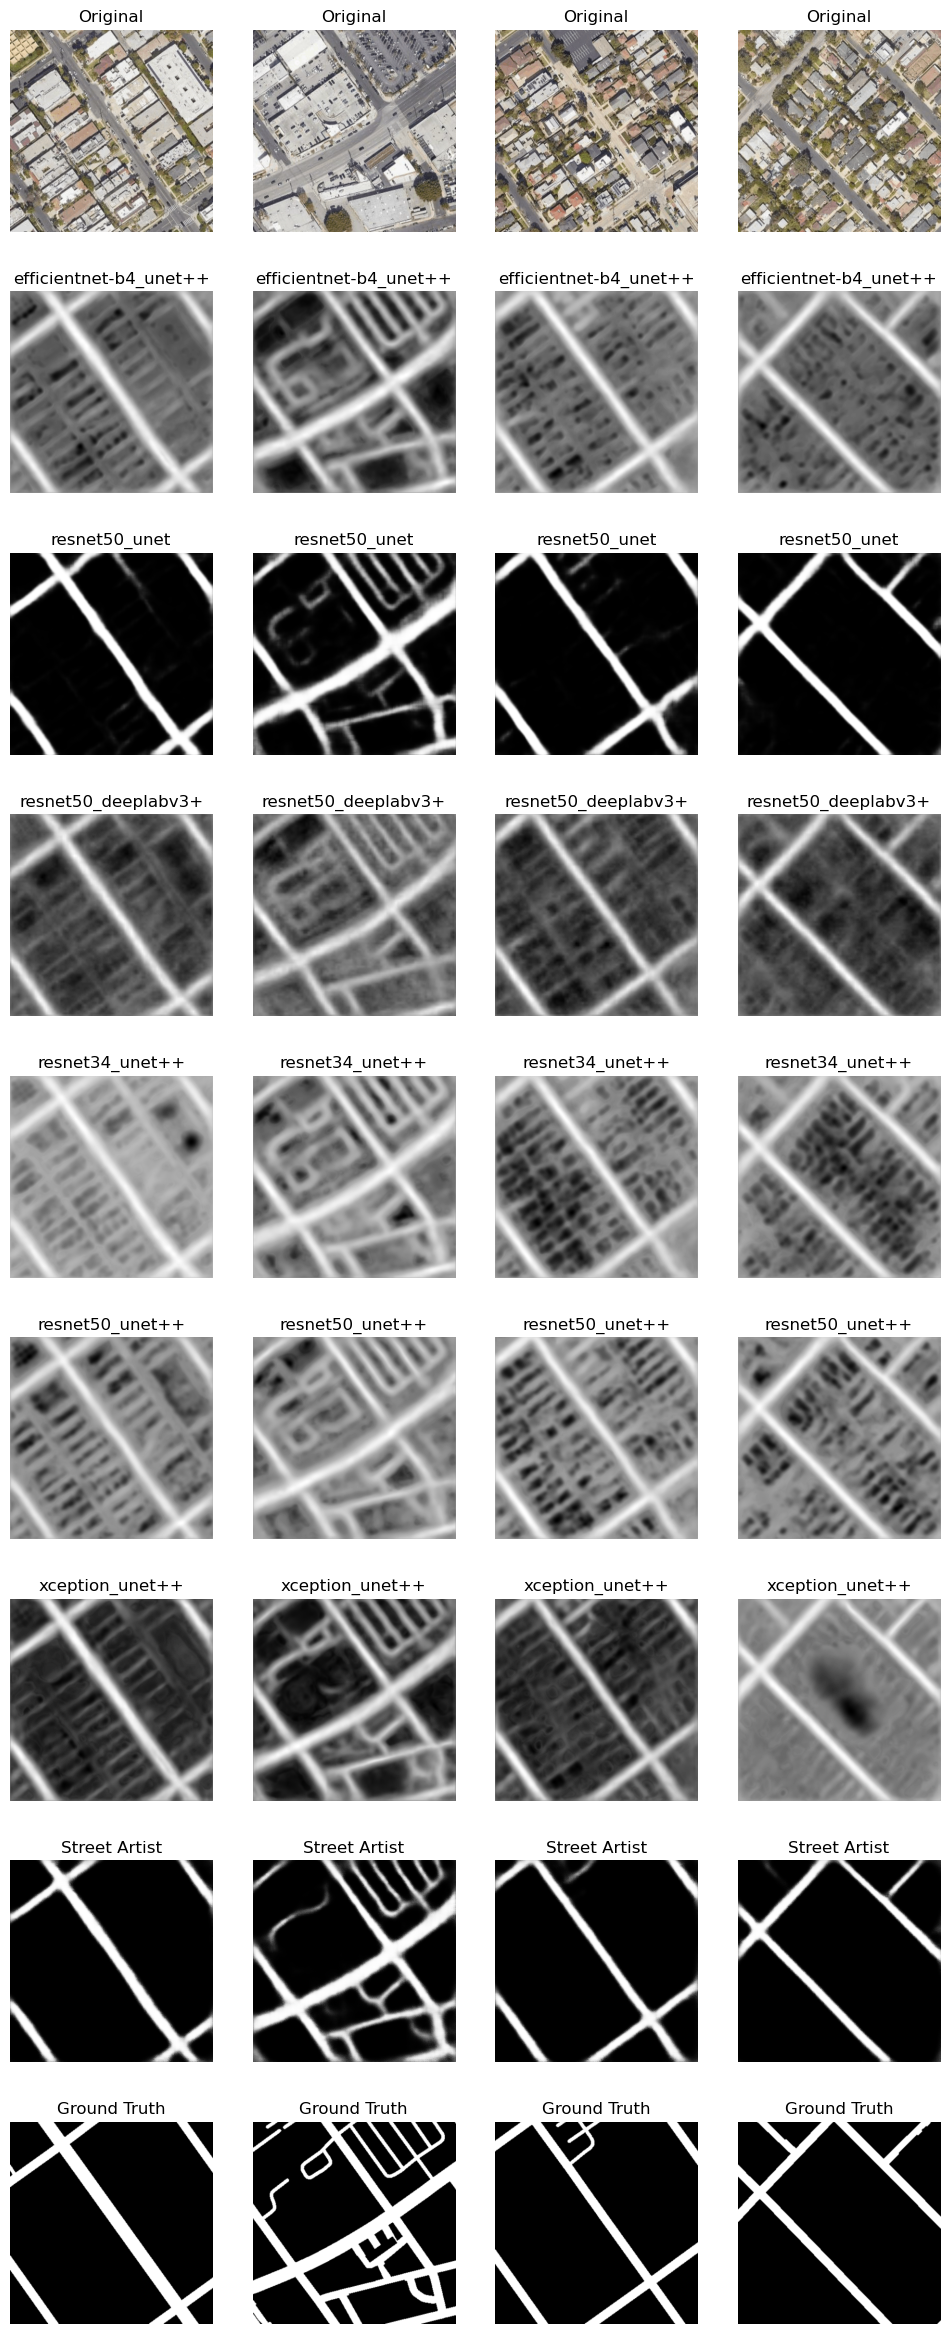

2024-07-30 09:18:19.402 | ERROR    | __main__:<module>:55 - list index out of range


2024-07-30 09:18:19 | 400514689 | list index out of range


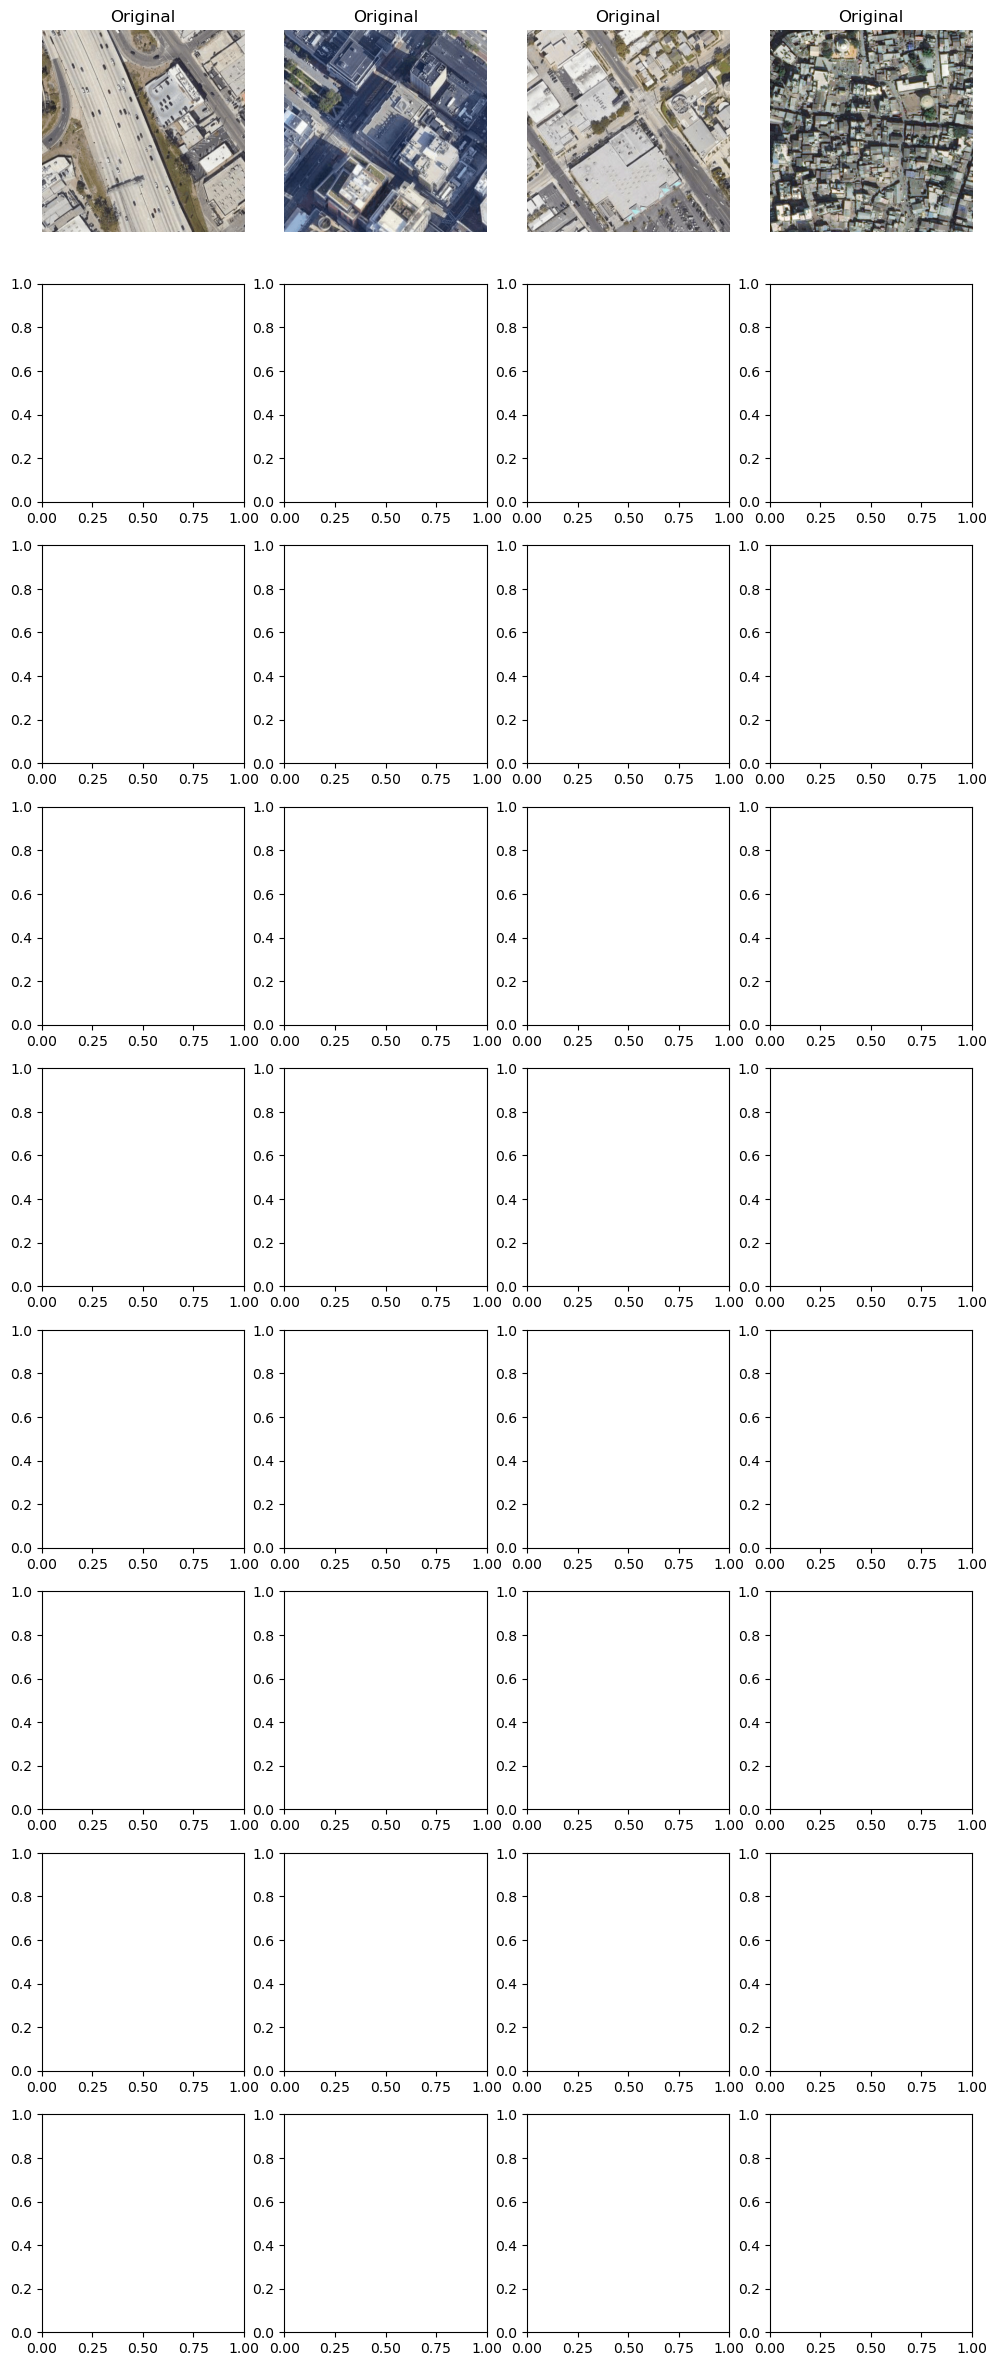

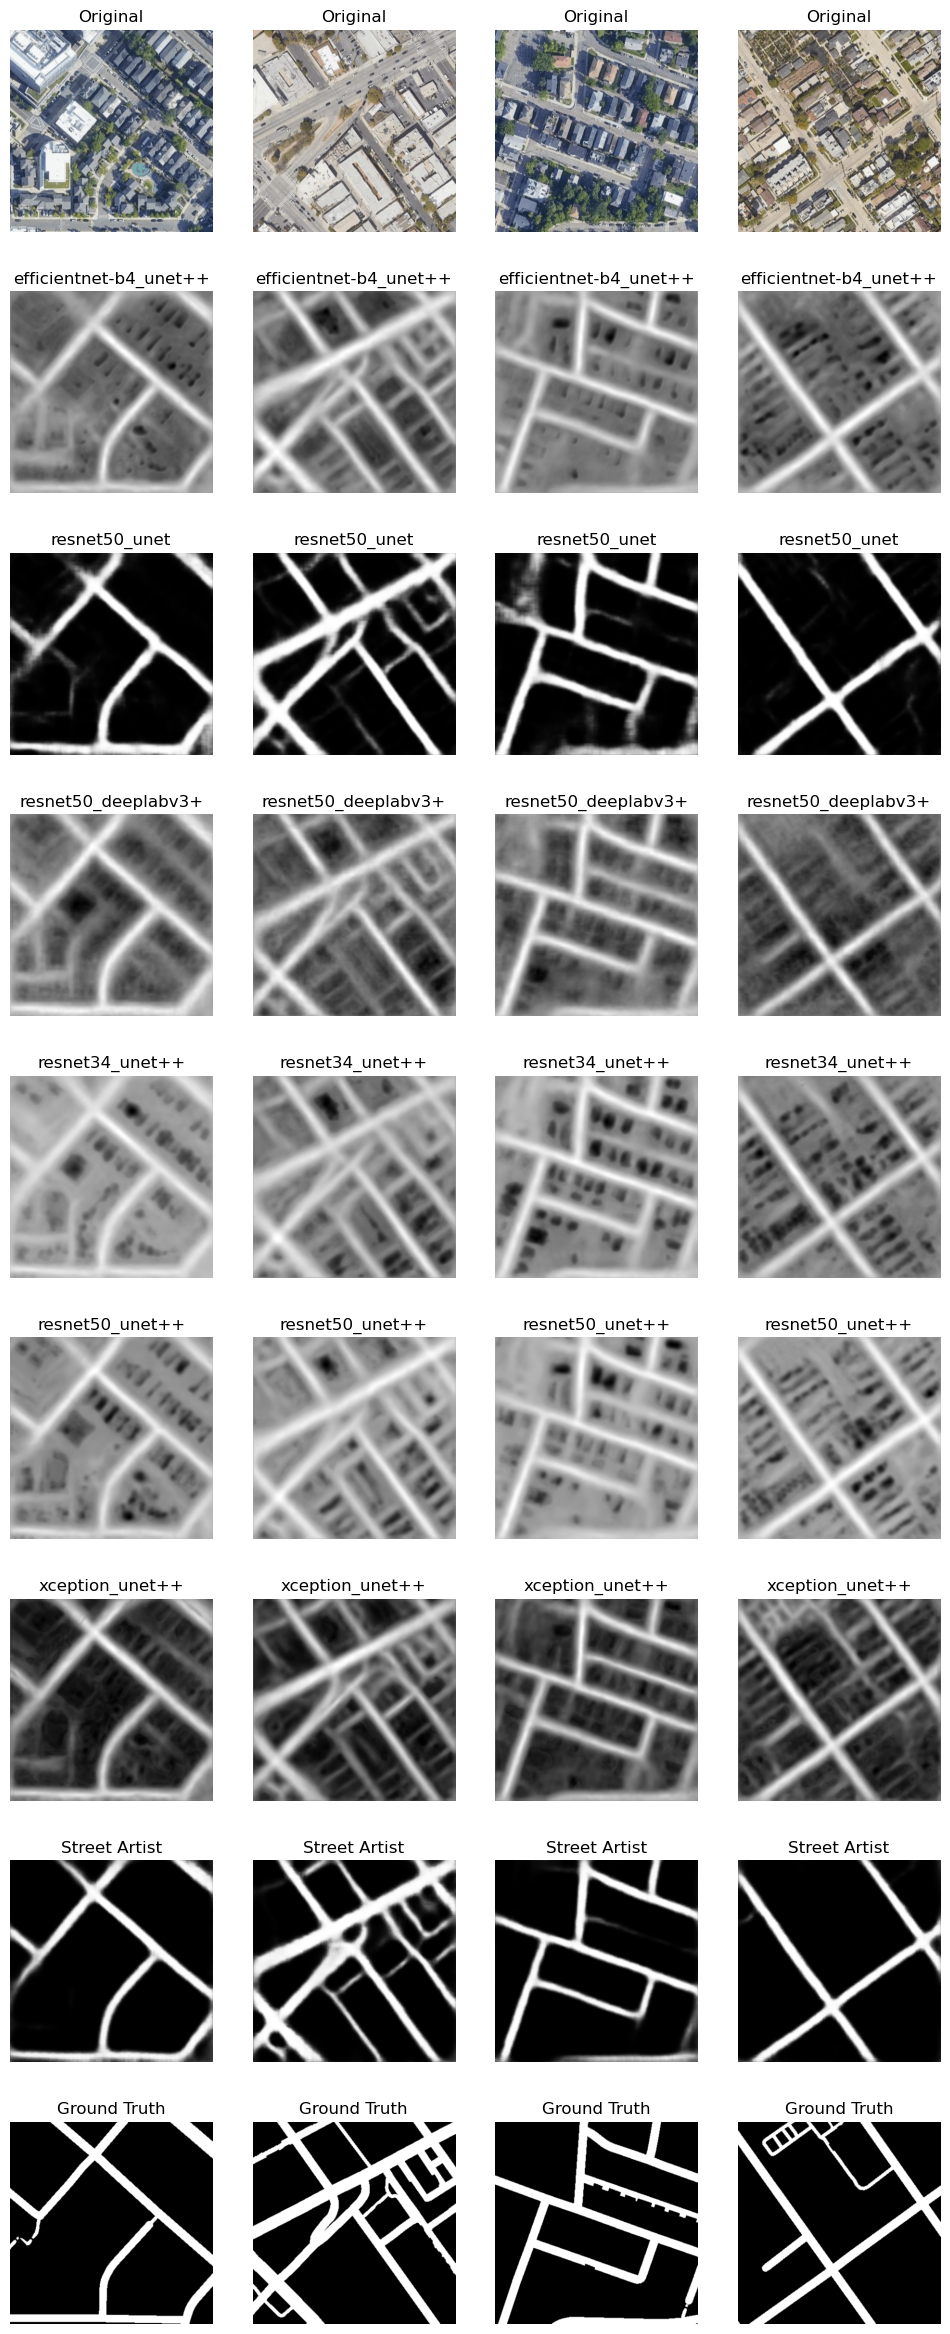

2024-07-30 09:18:49.787 | ERROR    | __main__:<module>:55 - list index out of range


2024-07-30 09:18:49 | 400514689 | list index out of range


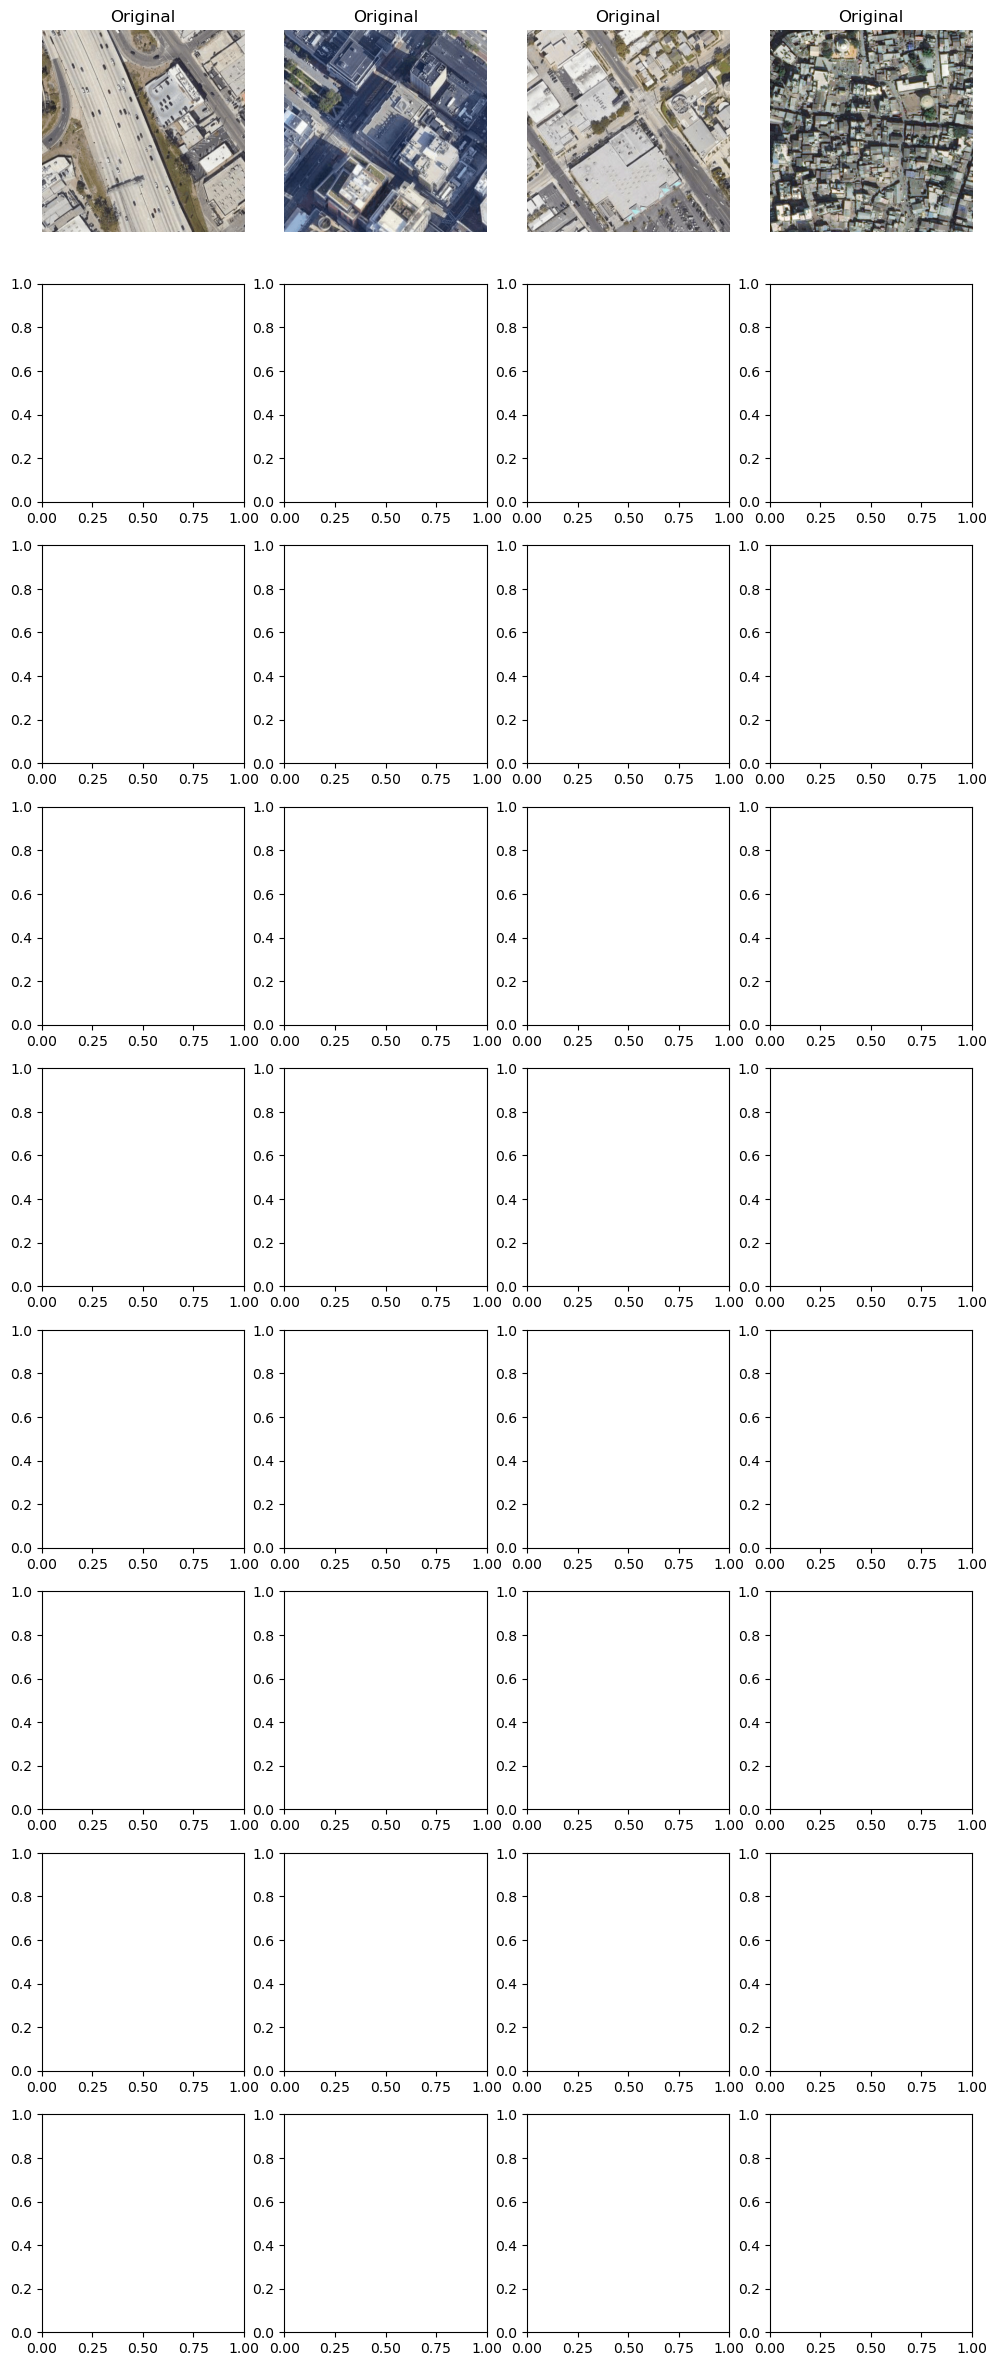

In [8]:
# TRAINING
nr_models = 6 # number of models to use in the street artist
model_configs_artist = model_configs[:nr_models]
models = [create_model(encoder_name, architecture) for encoder_name, architecture in model_configs_artist]
# load weights
for model, (encoder_name, architecture) in zip(models, model_configs_artist):
    model_name = f"{encoder_name}_{architecture}"
    submission_weights_path = os.listdir(submission_weights)
    submission_weights_path = [os.path.join(submission_weights, path) for path in submission_weights_path if path.startswith(model_name) and (not "++" in path or "unet++" in model_name)]
    submission_weights_path = sorted(submission_weights_path, key=lambda x: "finetuned" in x, reverse=True)
    submission_weights_path = submission_weights_path[0] if submission_weights_path else None
    print(submission_weights_path)
    model.load_state_dict(torch.load(submission_weights_path))
    model.to(device)

street_paint = StreetArtist(*models)
street_paint = street_paint.to(device)
optimizer = torch.optim.Adam(street_paint.parameters(), lr=lr)

# SETUP TRAINING FOR STREET PAINT
model_name = "street_paint" + "__".join([f"{encoder_name}_{architecture}" for encoder_name, architecture in model_configs_artist])
metric_fns = metric_fns_base
loss_fn = torch.nn.BCELoss() 

logger.info(f"Training model: {model_name}")
os.makedirs(submission_weights_path := "submission_weights", exist_ok=True)
os.makedirs(submission_checkpoints := "submission_checkpoints", exist_ok=True)

epoch_patience_options = [(17, 3), (19, 4)]

for nr_epochs_street_paint, patience_street_paint in epoch_patience_options:
    combined_train_dataloader, combined_validation_dataloader = get_dataloader(seed, device, batch_size=2)
    logger.info(f"Training for {nr_epochs_street_paint} epochs with patience {patience_street_paint}.")
    model_name += f"_{nr_epochs_street_paint}_{patience_street_paint}"
    if os.path.exists(submission_weights_path + "/" + model_name + ".pt"):
        logger.info(f"Loading model weights from {submission_weights_path + "/" + model_name + ".pt"}.")
        street_paint.load_state_dict(torch.load(submission_weights_path + "/" + model_name + ".pt"))
    else:
        utils.train(combined_train_dataloader, combined_validation_dataloader, street_paint, loss_fn, metric_fns, optimizer, nr_epochs_street_paint, patience_street_paint, model_name, submission_checkpoints)
        torch.save(street_paint.state_dict(), submission_weights_path + "/" + model_name + ".pt")

    # %%
    # combined_train_dataloader, combined_validation_dataloader = get_dataloader(seed, device, batch_size=4)
    street_paint.to(device)
    [street_paint.models[i].to(device) for i in range(len(street_paint.models))]
    [street_paint.models[i].eval() for i in range(len(street_paint.models))]
    street_paint.eval()

    # %%
    combined_train_dataloader, combined_validation_dataloader = get_dataloader(seed, device, batch_size=4)
    for _ in range(4):
        try:
            street_paint.visualize(combined_validation_dataloader)
        except Exception as e:
            logger.error(e)

    # %%
    # utils.create_test_submission(street_paint, device="cuda", submission_filename=os.path.join(submission_dir, f"{model_name.replace(".pt", "")}.csv"))


